In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from glob import glob
import json
import math
from matplotlib import rcParams
from collections import Counter
rcParams.update({'figure.autolayout': True})

In [ ]:
def classify_channels(filepath, savepath, country, expertlist, governmentlist):
  '''
  Opens the csv, separates the expert chanels and govt channels
  '''
  sourcedict = {}
  sepdict = {}
  for i in glob(filepath+country+'*.csv'):
    #with open(i, 'r') as readfile:
    #print(i)
    df = pd.read_csv(i, header=0, sep=',')
    for index, row in df.iterrows():
      urli = row['dom']
      if not pd.isnull(urli):
        #urli = urli.split('/')
        if len(urli)>2:
          if (row['total'])!=0:
            sentiment = (row['positive']-row['negative'])/(row['total'])#row['Total words']
            pf = (row['positive'])/(row['total'])
            nf = (row['negative'])/(row['total'])
            if urli not in sourcedict.keys():
              sourcedict[urli]=[sentiment]
              sepdict[urli]=[(pf,nf)]
            else:
              sourcedict[urli].append(sentiment)
              sepdict[urli].append((pf,nf))
    #============BLOCK2============
    sentavgs, ncount = [],[]
    avgdict = {}
    for key, value in sourcedict.items():
      if len(value)>0:
        sentavgs.append(np.average(value))
        ncount.append(len(value))
        avgdict[key] = np.average(value)
    #============BLOCK3============ VISUAL
    bbins = np.floor(len(sentavgs)/3)
    b1 = int(bbins)
    b2 = int(bbins)*2
    plt.style.use('ggplot')
    sortorder = np.argsort(sentavgs)
    plt.figure(figsize=(6,3), dpi=300)
    plt.scatter([sentavgs[i] for i in sortorder][:b1],[ncount[i] for i in sortorder][:b1], alpha=0.3, c='r', label='Ch 1')
    plt.scatter([sentavgs[i] for i in sortorder][b1:b2],[ncount[i] for i in sortorder][b1:b2], alpha=0.3, c='b', label='Ch 2')
    plt.scatter([sentavgs[i] for i in sortorder][b2:],[ncount[i] for i in sortorder][b2:], alpha=0.3, c='g', label='Ch 3')
    plt.xlabel('Source average sentiment')
    plt.ylabel('Number of news')
    plt.legend()
    plt.title(country+' channels')
    plt.tight_layout()

    plt.savefig(savepath+country+'_channels.png')
    #============BLOCK4===============
    '''
    Expert channels as separate list
    '''
    expertchannel = []
    #print(avgdict)
    expertstems = expertlist
    #Manual part
    for i in avgdict.keys():
      for j in expertstems:
        if j in i:
          expertchannel.append(i)
          #print(i)
    govchannel = []
    govstems = governmentlist
    #Manual part
    for i in avgdict.keys():
      for j in govstems:
        if j in i:
          govchannel.append(i)
    #============BLOCK5===============
    '''
    Binning the channels into 3 + expert + gov

    '''
    nsources = len(sentavgs) - len(govchannel) - len(expertchannel)
    bbins = np.floor(nsources/3)
    b1 = int(bbins)
    b2 = int(bbins)*2
    sortdict = {k: v for k, v in sorted(avgdict.items(), key=lambda item: item[1])}
    sourcelist = [i for i in list(sortdict.keys()) if i not in expertchannel and i not in govchannel]
    counter = 1
    source2ch = {}
    #print(len(sourcelist))
    #print(bbins)
    for i in range(len(sourcelist)):
      if sourcelist[i] not in expertchannel and sourcelist[i] not in govchannel:
        source2ch[sourcelist[i]] = counter
      if i+1 > b1*counter:
        counter+=1

    for i in expertchannel:
      source2ch[i] = 'E'
    for i in govchannel:
      source2ch[i] = 'G'
    print('Sources in each channel:')
    print(Counter([i for i in source2ch.values()]))
    #============BLOCK6===============
    #print(source2ch)
    timelines = {}
    for i in glob(filepath+country+'*.csv'):
      #with open(i, 'r') as readfile:
      #print(i)
      df = pd.read_csv(i, header=0, sep=',')
      for index, row in df.iterrows():
        urli = row['dom']
        if not pd.isnull(urli):
          #urli = urli.split('/')
          if len(urli)>2:
            if (row['total'])!=0:
              sentiment = (row['positive']-row['negative'])/(row['total'])#row['Total words']#row['Total words']
              pf = (row['positive'])/(row['total'])
              nf = (row['negative'])/(row['total'])
              ndate = int(str(row['date']).replace('filtered_',''))
              if ndate not in timelines.keys():
                timelines[ndate] = {'E':[],'G':[], 1:[],2:[],3:[]}
              #print(ndate, urli, [source2ch[urli]])
              timelines[ndate][source2ch[urli]].append(sentiment)
    with open(savepath+country+'_channels.json', 'w') as fp:
      json.dump(timelines, fp)

    #Save the avgs etc.

    sortedtimeline = sorted(list(timelines.keys()))
    channelaverages = []
    channelvariances = []
    for d in sortedtimeline:
      
      exp = timelines[d]['E']
      gov = timelines[d]['G']
      ch1 = timelines[d][1]
      ch2 = timelines[d][2]
      ch3 = timelines[d][3]
      allsources = gov+exp+ch1+ch2+ch3
      channelaverages.append([np.average(allsources), np.average(exp), np.average(gov), np.average(ch1), np.average(ch2), np.average(ch3)])
      channelvariances.append([np.var(allsources),np.var(exp),np.var(gov), np.var(ch1), np.var(ch2), np.var(ch3)])

    chvars = np.asarray(channelvariances).T
    chavgs = np.asarray(channelaverages).T
    tmpdf = pd.DataFrame({'Date':sortedtimeline, 'All_mean':chavgs[0], 'E_mean':chavgs[1],'G_mean':chavgs[2], 'ch1_mean':chavgs[3], 'ch2_mean':chavgs[4], 'ch3_mean':chavgs[5],'All_var': chvars[0],'E_var':chvars[1], 'G_var':chvars[2], 'ch1_var':chvars[3], 'ch2_var': chvars[4], 'ch3_var':chvars[5]})

    tmpdf.to_csv(savepath+country+'_processed.csv')

    #==============BLOCK7============= VISUAL
    plt.figure(figsize=(6,3), dpi=300)
    plt.xlabel('Time')
    plt.ylabel('Sentiment')
    plt.title(country+' sentiment timeseries')
    chlabels = ['exp','gov','ch1','ch2','ch3']
    lblc =0
    for i in chavgs[1:]:
      plt.plot(np.arange(len(i)), i, label=chlabels[lblc])
      lblc+=1
    plt.legend(loc='upper left')
    ticks = []
    ticklabels = []
    for i in range(len(sortedtimeline)):
      if str(sortedtimeline[i])[-2:] == '01':
        ticks.append(i)
        ticklabels.append(str(sortedtimeline[i])[-4:-2]+'/'+str(sortedtimeline[i])[-2:])
    plt.xticks(ticks,ticklabels)

    plt.tight_layout()
    plt.savefig(savepath+country+'_timeseries.png')
    #=============BLOCK8=============== VISUAL
    plt.figure(figsize=(6,3), dpi=300)
    plt.xlabel('Time')
    plt.ylabel('Sentiment variance')
    plt.title(country+' sentiment variance timeseries')
    chlabels = ['exp','gov','ch1','ch2','ch3']
    lblc =0
    for i in chvars[1:]:
      plt.plot(np.arange(len(i)), i, label=chlabels[lblc])
      lblc+=1
    plt.legend(loc='upper left')
    ticks = []
    ticklabels = []
    for i in range(len(sortedtimeline)):
      if str(sortedtimeline[i])[-2:] == '01':
        ticks.append(i)
        ticklabels.append(str(sortedtimeline[i])[-4:-2]+'/'+str(sortedtimeline[i])[-2:])
    plt.xticks(ticks,ticklabels)

    plt.tight_layout()
    plt.savefig(savepath+country+'_timeseries_var.png')

    #===============BLOCK9===============
    return source2ch, expertchannel, govchannel

Sources in each channel:
Counter({1: 19, 2: 18, 3: 18, 'G': 4, 'E': 2})


'\nYou can also make a list of countries and process all of them in a loop:\ncountries = [...]\nexpertlist = [[...],[...],...]\ngovernmentlist = [[...],[...],...]\nfor i in range(len(countries)):\n  classify_chanels(fpath, savepath, countries[i], expertlist[i], governmentlist[i])\n'

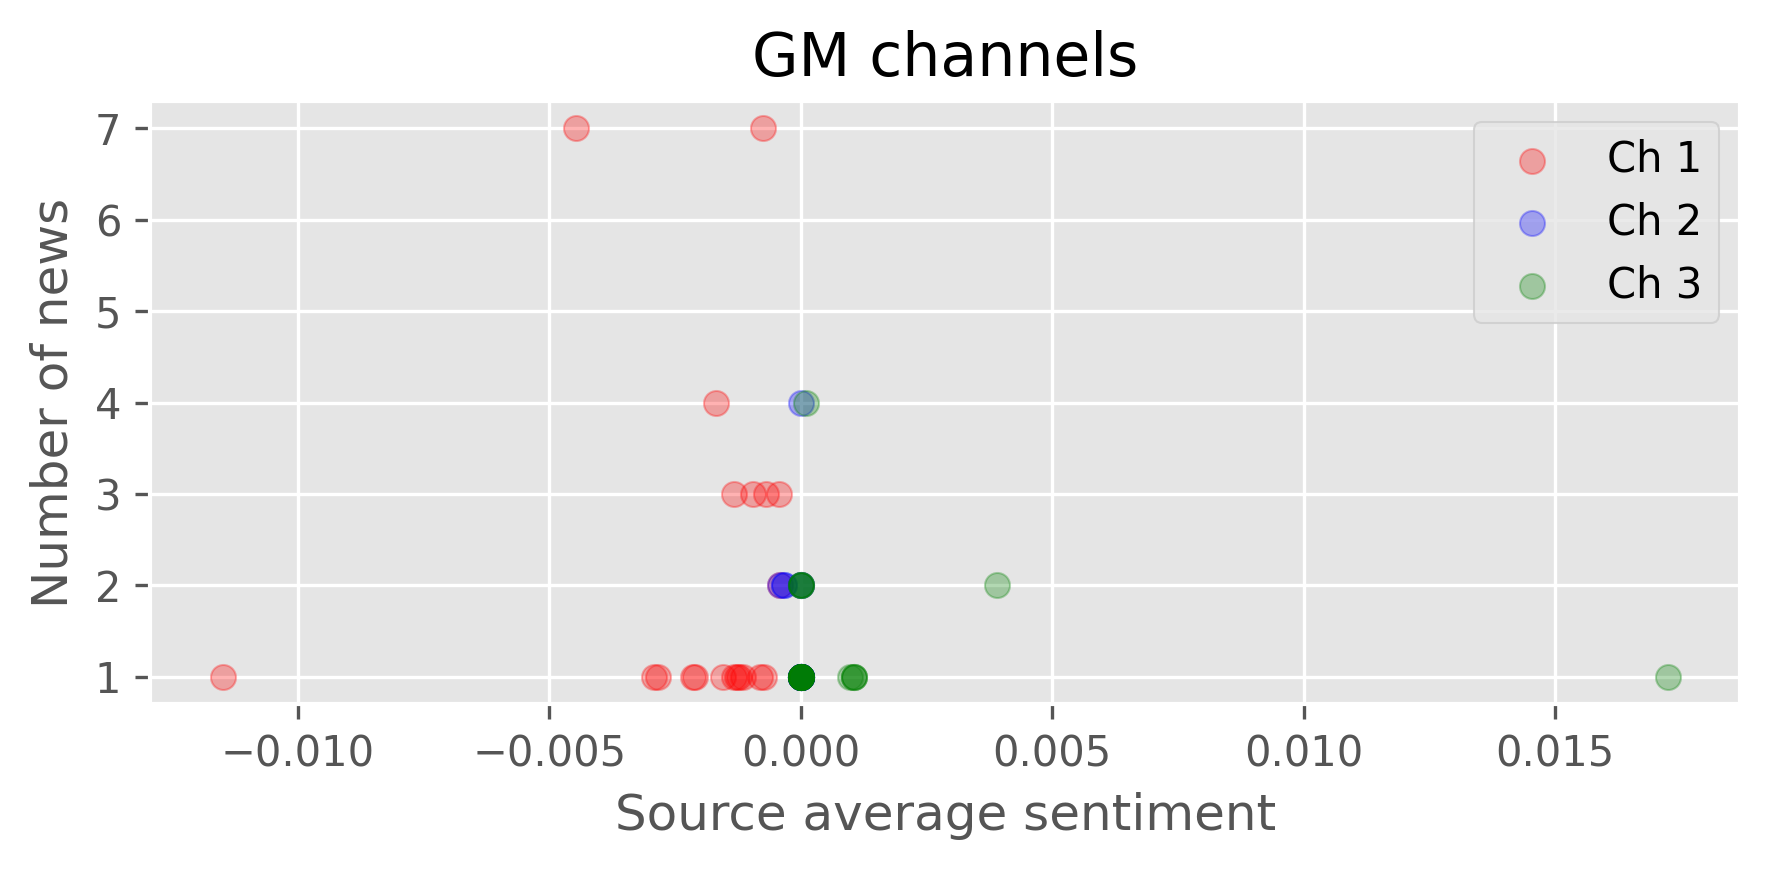

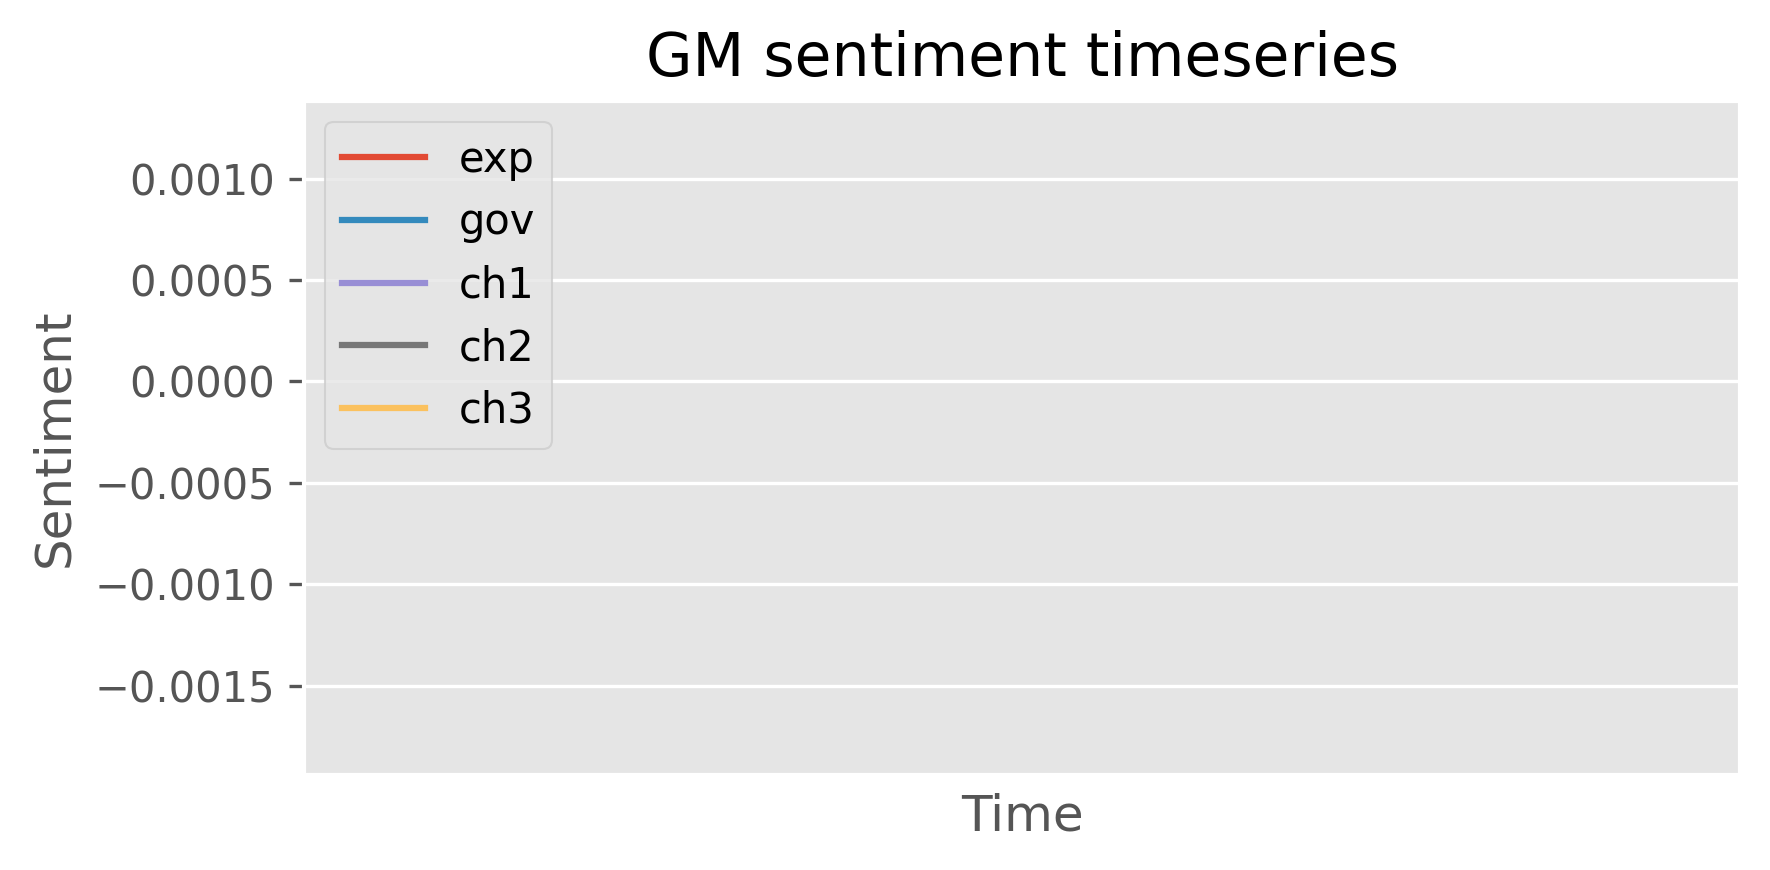

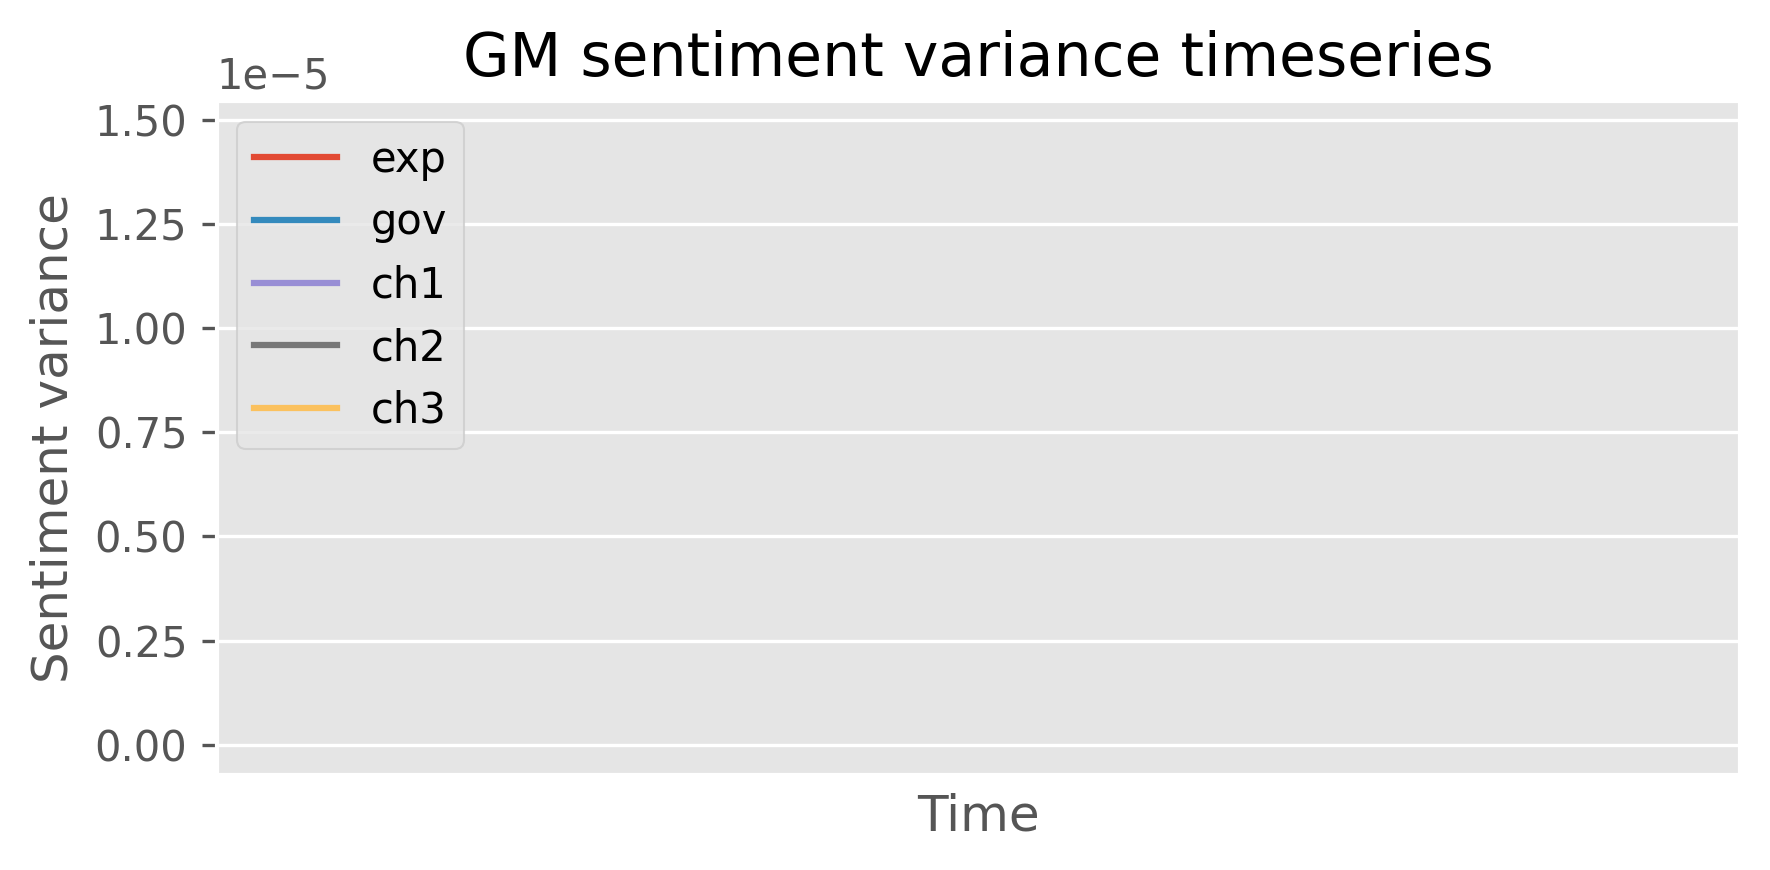

In [ ]:
fpath = r'/content/drive/Shared drives/FNA XN Spring 2020 Project 4/Data/fixed_data/' #Change
country = 'GM' #Change to the one you are currently processing
savepath = r'/content/drive/My Drive/' #Change
expertlist = ['faz','welt.de'] #Bogus examples for debugging, please change
governmentlist = ['focus', 'dw.com', 'news.de'] #Bogus examples for debugging, please change

classify_channels(fpath,savepath,country,expertlist,governmentlist)

'''
You can also make a list of countries and process all of them in a loop:
countries = [...]
expertlist = [[...],[...],...]
governmentlist = [[...],[...],...]
for i in range(len(countries)):
  classify_chanels(fpath, savepath, countries[i], expertlist[i], governmentlist[i])
'''